In [1]:
#!wget https://github.com/dsbattle/hackathon-mkb/raw/master/train_dataset_hackathon_mkb.csv
#!wget https://github.com/dsbattle/hackathon-mkb/raw/master/test_dataset_hackathon_mkb.csv

In [2]:
#pip install category_encoders

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
import multiprocessing
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from lightgbm import plot_importance

In [4]:
initial_train = pd.read_csv('./train_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
initial_test = pd.read_csv('./test_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')

In [5]:
columns = initial_train.columns.to_list()
financial_columns = [col for col in columns if col.startswith(('F1', 'F2'))]
discrete_columns = [col for col in columns if ('NUMBER' in col) or ('COUNT' in col) or ('THIRDOROTH' in col) \
                                                                                                            or ('DISQ' in col)]
sum_columns = [col for col in columns if 'SUM' in col]
numeric_columns = financial_columns + discrete_columns + sum_columns
useless_columns = ['id_contract', 'EGRPOINCLUDED', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE', 'BIRTHDATE', 'AGE']
date_columns = ['SIGN_DATE', 'DATEFIRSTREG']
target_col = ['TARGET']
categorical_few_columns = ['CITIZENSHIP_NAME', 'OKFS_GROUP', 'OKOGU_GROUP', 'OKOPF_GROUP', 'OKTMO_FED', 'SEX_NAME',
                                                                                                'OKATO_FED', 'WORKERSRANGE']
categorical_many_columns = ['OKATO_REGIONCODE', 'OKTMO_CODE', 'OKVED_CODE']
categorical_columns = categorical_few_columns + categorical_many_columns
columns = [col for col in columns if col not in useless_columns]
train_length = len(initial_train)
test_length = len(initial_test)

In [6]:
train = initial_train
test = initial_test
df = pd.concat([train, test], ignore_index=True)

In [7]:
df.drop(columns = useless_columns, inplace = True)
for col in date_columns:
    df[col] = df[col].apply(lambda date : datetime.strptime(date, '%d%b%Y:%H:%M:%S') if pd.notna(date) else np.nan)
df['DATEFIRSTREG'] = df['DATEFIRSTREG'].fillna(datetime(2020, 1, 1, 0, 0, 0))
df['day_of_the_year'] = df['SIGN_DATE'].apply(lambda sign_date : sign_date.timetuple().tm_yday)
df['days_registred'] = (df['SIGN_DATE'] - df['DATEFIRSTREG']).apply(lambda delta : delta.days)
df[numeric_columns] = df[numeric_columns].fillna(0)
df['Id'] = df.index
df['n_before'] = df[['id_client', 'Id']].groupby(['id_client']).cumcount()
df['Year'] = df['SIGN_DATE'].apply(lambda sign_date : sign_date.year)
df['Month'] = df['SIGN_DATE'].apply(lambda sign_date : sign_date.month)

In [8]:
last_3_days_count = df.groupby('id_client', group_keys=False).apply(lambda group : group.rolling('3D', on = 'SIGN_DATE')['Id'].count())
df['last_3_days_count'] = last_3_days_count

In [9]:
mean_last_3_days = df.groupby('id_client', group_keys=False).apply(lambda group : group['last_3_days_count'].cumsum().divide(group['n_before'] + 1.0))
df['mean_last_3_days'] = mean_last_3_days

In [10]:
#s = df.count() < 25221
#s[s].index.to_list()

In [11]:
ordinal_enc_columns = ['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'SEX_NAME', 'CITIZENSHIP_NAME']
no_enc_columns = ['OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_FED']

enc = OrdinalEncoder()
df[ordinal_enc_columns] = pd.DataFrame(enc.fit_transform(df[ordinal_enc_columns])).fillna(-1)
df[no_enc_columns] = df[no_enc_columns].fillna(-1)

In [12]:
df['WORKERSRANGE'] = df['WORKERSRANGE'].map({np.nan : -1, '0 .. 5' : 0, '6 .. 10' : 1, '11 .. 15' : 2, '16 .. 50' : 3, '51 .. 100' : 4,
                                '101 .. 150' : 5, '151 .. 200' : 6, '201 .. 250' : 7, '251 .. 500' : 8, '501 .. 1000' : 9, 
                                                                            '1001 .. 5000' : 10, '5000 и более' : 11})

In [13]:
df['OKVED_CODE_1'] = df['OKVED_CODE'].apply(lambda code : float(code.split('.')[0]) if pd.notna(code) else -1)

In [14]:
df['OKVED_CODE_2'] = df['OKVED_CODE'].apply(lambda code : float(code.split('.')[1]) if (pd.notna(code) and len(code.split('.')) > 1) else -1)

In [15]:
df['OKVED_CODE_3'] = df['OKVED_CODE'].apply(lambda code : float(code.split('.')[2]) if (pd.notna(code) and len(code.split('.')) > 2) else -1)

In [16]:
df.drop(columns = ['OKTMO_CODE'], inplace = True)

In [17]:
df.drop(columns = ['Id', 'id_client', 'SIGN_DATE', 'DATEFIRSTREG', 'OKVED_CODE'], inplace=True)

In [18]:
train = df.iloc[:train_length-1]
test = df.iloc[train_length:]
test = test.drop(columns = ['TARGET'])
#df

In [19]:
y = train['TARGET']
X = train.drop(columns = ['TARGET'])

In [20]:
X_train = X.iloc[:12500, :]
X_val = X.iloc[12501:, :]
y_train = y.iloc[:12500]
y_val = y.iloc[12501:]

In [21]:
w = {0: 1, 1: 1}

#model = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, random_state=0, class_weight=w, n_jobs=multiprocessing.cpu_count())

#model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, n_estimators=200, learning_rate=0.2, max_depth=3)

model = lgb.LGBMClassifier(n_estimators = 200, learning_rate=0.03, class_weight = w)

In [22]:
pipe = Pipeline([ ('model', model)])

pipe.fit(X_train, y_train)
y_score = pipe.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_score)

0.9606572423408712

In [23]:
pipe = Pipeline([('model', model)])

pipe.fit(X, y)

Pipeline(steps=[('model',
                 LGBMClassifier(class_weight={0: 1, 1: 1}, learning_rate=0.03,
                                n_estimators=200))])

In [24]:
test_id_contract = initial_test['id_contract']
submission = pd.DataFrame()
submission['TARGET'] = pipe.predict_proba(test)[:, 1]
submission['id_contract'] = test_id_contract

In [25]:
submission[['id_contract', 'TARGET']].head()                                            # New

,id_contract,TARGET
0,17892,0.021615
1,17893,0.070630
2,17894,0.178853
3,17895,0.326348
4,17896,0.861495


In [26]:
submission[['id_contract', 'TARGET']].head()                                            # New

,id_contract,TARGET
0,17892,0.021615
1,17893,0.070630
2,17894,0.178853
3,17895,0.326348
4,17896,0.861495


In [27]:
submission[['id_contract', 'TARGET']].to_csv('submit_file_6.csv', sep=';', index=False)   

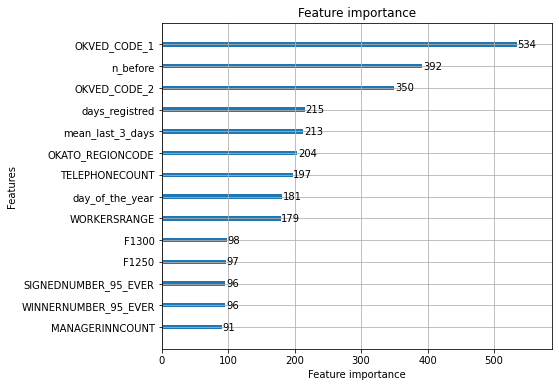

In [28]:
plot_importance(pipe['model'], max_num_features=14, figsize = (7, 6))